# <font color='blue'>European Sales Dataset</font>
## <font color='black'>EDA & Linear Regression on Sales per Capita and Computer Sales</font>

### Importing Data & Preprocessing

We first install the packages we need and set the output figure size:

In [7]:
library(tidyverse)
library(corrplot)
library(psych)
library(leaps)

In [8]:
options(repr.plot.width=6, repr.plot.height=4.5)

We read the data into R. The dataset consists of 21 rows and 7 columns.

In [9]:
df_raw = read.csv('EuropeanSales.csv', header=TRUE)

df_raw[sample(nrow(df_raw), 5), ]
summary(df_raw)

,Country,Population,GDPperHead,UnemploymentRate,EducationSpending,SalesPerCapita,ComputerSales
1,Austria,8.4,49.60,4.2,5.8,112,941
10,Hungary,10.0,15.41,7.3,5.1,45,449
20,Turkey,75.8,9.94,8.6,3.7,38,2879
19,Sweden,9.2,51.95,6.3,7.6,230,2113
15,Portugal,10.7,22.92,6.3,5.9,68,729


       Country     Population      GDPperHead    UnemploymentRate
 Austria   : 1   Min.   : 4.40   Min.   : 6.55   Min.   : 3.6    
 Belgium   : 1   1st Qu.: 8.40   1st Qu.:20.67   1st Qu.: 6.3    
 Bulgaria  : 1   Median :10.70   Median :43.54   Median : 7.3    
 Czech Rep.: 1   Mean   :26.72   Mean   :36.97   Mean   : 8.1    
 Denmark   : 1   3rd Qu.:44.80   3rd Qu.:51.32   3rd Qu.: 9.9    
 Finland   : 1   Max.   :82.50   Max.   :64.43   Max.   :14.4    
 (Other)   :15                                                   
 EducationSpending SalesPerCapita  ComputerSales 
 Min.   :3.300     Min.   : 20.0   Min.   : 154  
 1st Qu.:4.400     1st Qu.: 68.0   1st Qu.: 813  
 Median :5.000     Median :101.0   Median :1682  
 Mean   :5.181     Mean   :115.3   Mean   :2493  
 3rd Qu.:5.800     3rd Qu.:151.0   3rd Qu.:2879  
 Max.   :8.400     Max.   :372.0   Max.   :9887  
                                                 

It seems like **Country** column does not carry much information other than names of the countries. We check this assumption.

In [10]:
nrow(df_raw) == length(levels(df_raw$Country))

[1] TRUE

It is correct, this column has as many unique values as the number of rows. We convert **Country** to Row ID (keys) and take a new sample.

In [11]:
df = df_raw %>% remove_rownames %>% column_to_rownames(var="Country")
df[sample(nrow(df), 5), ]

,Population,GDPperHead,UnemploymentRate,EducationSpending,SalesPerCapita,ComputerSales
Germany,82.5,44.45,9.1,4.6,83,6824
Greece,11.2,31.67,9.9,3.9,73,813
Denmark,5.5,62.12,5.2,8.4,170,935
Belgium,10.5,47.09,8.1,5.9,160,1682
Austria,8.4,49.60,4.2,5.8,112,941


### Exploratory Data Analysis

We create a boxplot for all of our features using **facet_wrap**. It seems like there are 4 outliers.

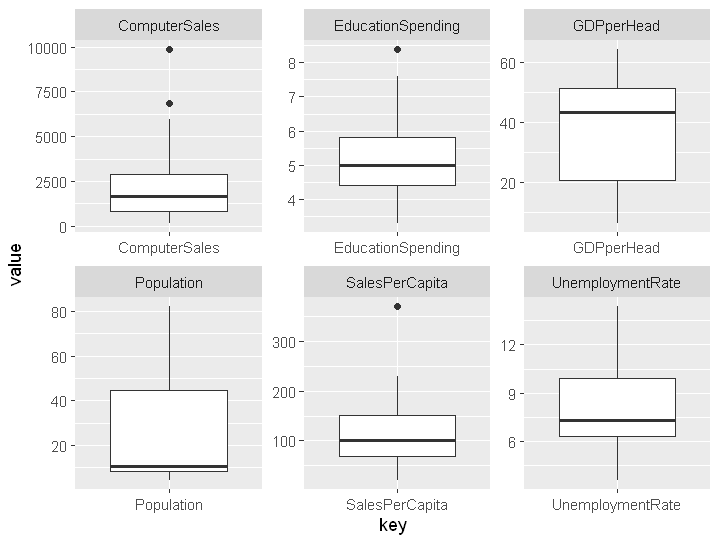

In [12]:
ggplot(data = gather(df), aes(x=key, y=value)) + 
    geom_boxplot() + 
    facet_wrap( ~key, scales="free")

We check what these outliers are using **filter** function.

In [13]:
df_raw %>% filter(ComputerSales > 6500 | EducationSpending > 8 | SalesPerCapita > 300)

Country,Population,GDPperHead,UnemploymentRate,EducationSpending,SalesPerCapita,ComputerSales
Denmark,5.5,62.12,5.2,8.4,170,935
Finland,5.3,51.32,9.9,6.3,372,1971
Germany,82.5,44.45,9.1,4.6,83,6824
UK,61.0,43.54,5.9,4.8,162,9887


These outliers are not errors, they are actual countries. While it is tempting to remove this data points, they will not be removed. We already have too few data points (21) and these 4 data points carry relevant information.

Next, we create a correlation matrix for our variables.

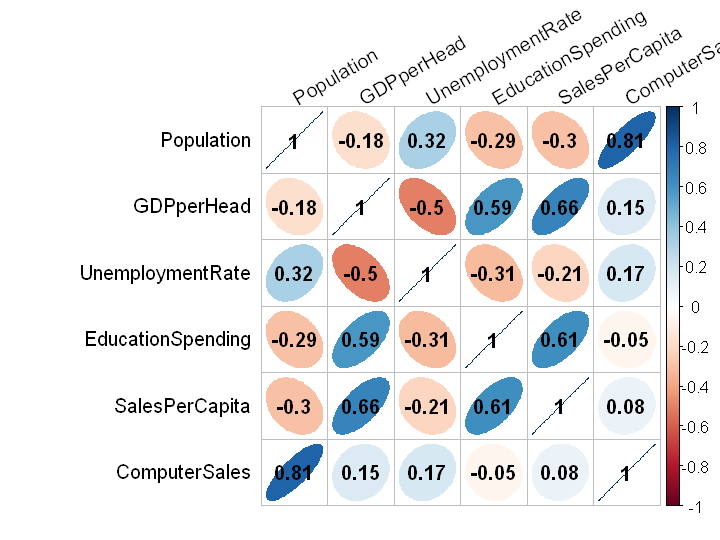

In [68]:
corrs = cor(df, method = "pearson")
corrplot(corrs, type = "full", method="ellipse", tl.col="black", tl.srt = 30, addCoef.col = "black")

We will have two target variables, **SalesPerCapita** and **ComputerSales**.

**SalesPerCapita** seems to have a relatively high correlation with **GDPperHead** and **EducationSpending**.

**ComputerSales** only has a correlation with **Population**. Its relationship with other variables are not strong.

We should also check the scatterplots for variable pairs. It would take too much space to do and too much time to inspect when it is done 1-by-1. Nevertheless below is the relevant code for that. We opt for using **pairs.panels**, a strong function from **psych** package.

In [15]:
#ggplot(data = df, aes(x = Population, y = ComputerSales)) +
#    geom_point() +
#    geom_smooth(method='lm',formula=y~x)

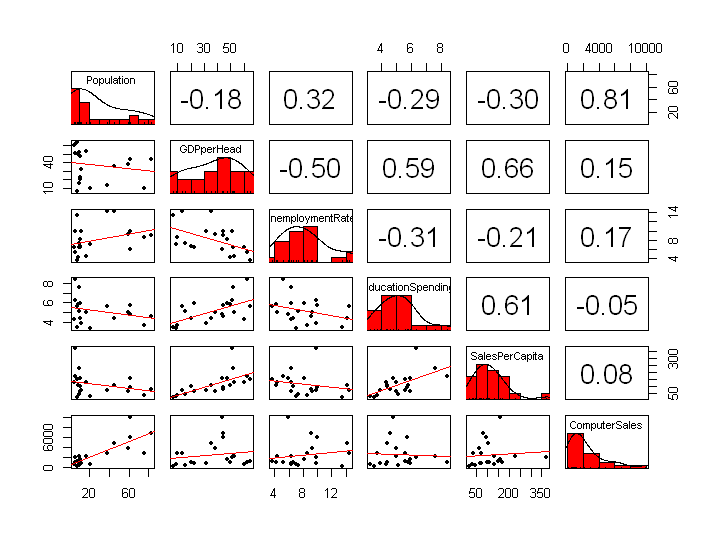

In [73]:
pairs.panels(df, ellipses=FALSE, hist.col="red", lm=TRUE)

The relationships we deduced using coefficients of correlation still hold. In fact, if not for the outliers, correlations of **SalesPerCapita** ~ **GDPperHead** and **SalesPerCapita** ~ **EducationSpending** would be even higher.

### Linear Regression for SalesPerCapita and ComputerSales

The method for choosing the correct features in the linear regression is not a deterministic one. While powerful, stepwise forward or backward analysis might cause us to miss some subsets of features that would otherwise offer strong models.

For this reason, **leaps** function was used to return which subsets of features should be checked for each subset size. Afterwards, linear models for all of these subsets were created.

In [70]:
leaps_SPC = regsubsets(SalesPerCapita ~ Population + GDPperHead + UnemploymentRate + EducationSpending + ComputerSales, data = df)
summary(leaps_SPC)

Subset selection object
Call: regsubsets.formula(SalesPerCapita ~ Population + GDPperHead + 
    UnemploymentRate + EducationSpending + ComputerSales, data = df)
5 Variables  (and intercept)
                  Forced in Forced out
Population            FALSE      FALSE
GDPperHead            FALSE      FALSE
UnemploymentRate      FALSE      FALSE
EducationSpending     FALSE      FALSE
ComputerSales         FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: exhaustive
         Population GDPperHead UnemploymentRate EducationSpending ComputerSales
1  ( 1 ) " "        "*"        " "              " "               " "          
2  ( 1 ) " "        "*"        " "              "*"               " "          
3  ( 1 ) "*"        "*"        " "              " "               "*"          
4  ( 1 ) "*"        "*"        " "              "*"               "*"          
5  ( 1 ) "*"        "*"        "*"              "*"               "*"          

In [18]:
fit1 <- lm(SalesPerCapita ~ Population + GDPperHead + UnemploymentRate + EducationSpending + ComputerSales, data = df)
fit2 <- lm(SalesPerCapita ~ Population + GDPperHead + EducationSpending + ComputerSales, data = df)
fit3 <- lm(SalesPerCapita ~ Population + GDPperHead + ComputerSales, data = df)
fit4 <- lm(SalesPerCapita ~ GDPperHead + EducationSpending, data = df)
fit5 <- lm(SalesPerCapita ~ GDPperHead, data = df)

summary(fit1)
summary(fit2)
summary(fit3)
summary(fit4)
summary(fit5)


Call:
lm(formula = SalesPerCapita ~ Population + GDPperHead + UnemploymentRate + 
    EducationSpending + ComputerSales, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.918 -25.813 -13.098   2.198 172.776 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -69.012454  79.194394  -0.871   0.3973  
Population         -1.782031   0.963337  -1.850   0.0841 .
GDPperHead          1.776939   1.011649   1.756   0.0994 .
UnemploymentRate    4.856949   4.863346   0.999   0.3338  
EducationSpending  17.266407  12.612351   1.369   0.1911  
ComputerSales       0.015031   0.009943   1.512   0.1514  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 56.09 on 15 degrees of freedom
Multiple R-squared:  0.6216,	Adjusted R-squared:  0.4955 
F-statistic: 4.928 on 5 and 15 DF,  p-value: 0.007235



Call:
lm(formula = SalesPerCapita ~ Population + GDPperHead + EducationSpending + 
    ComputerSales, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.663 -20.079 -12.263   3.392 188.984 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -20.076775  62.210155  -0.323   0.7511  
Population         -1.728230   0.961751  -1.797   0.0912 .
GDPperHead          1.341203   0.912651   1.470   0.1611  
EducationSpending  17.720604  12.603113   1.406   0.1788  
ComputerSales       0.016125   0.009881   1.632   0.1222  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 56.09 on 16 degrees of freedom
Multiple R-squared:  0.5964,	Adjusted R-squared:  0.4955 
F-statistic: 5.912 on 4 and 16 DF,  p-value: 0.00406



Call:
lm(formula = SalesPerCapita ~ Population + GDPperHead + ComputerSales, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.239 -30.548 -12.366   6.544 195.112 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)   52.38500   35.83227   1.462   0.1620  
Population    -1.95785    0.97464  -2.009   0.0607 .
GDPperHead     1.98043    0.81378   2.434   0.0263 *
ComputerSales  0.01687    0.01015   1.662   0.1148  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 57.68 on 17 degrees of freedom
Multiple R-squared:  0.5466,	Adjusted R-squared:  0.4666 
F-statistic: 6.831 on 3 and 17 DF,  p-value: 0.003181



Call:
lm(formula = SalesPerCapita ~ GDPperHead + EducationSpending, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-62.579 -34.667  -4.874  10.558 204.949 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -66.5294    54.8485  -1.213   0.2408  
GDPperHead          1.9555     0.8608   2.272   0.0356 *
EducationSpending  21.1470    12.6445   1.672   0.1117  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 58.03 on 18 degrees of freedom
Multiple R-squared:  0.5141,	Adjusted R-squared:  0.4601 
F-statistic: 9.522 on 2 and 18 DF,  p-value: 0.00151



Call:
lm(formula = SalesPerCapita ~ GDPperHead, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-53.584 -38.731  -9.879  16.306 216.447 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  11.6761    29.9902   0.389  0.70136   
GDPperHead    2.8035     0.7277   3.853  0.00107 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 60.71 on 19 degrees of freedom
Multiple R-squared:  0.4386,	Adjusted R-squared:  0.409 
F-statistic: 14.84 on 1 and 19 DF,  p-value: 0.001073


Best model in terms of Adjusted R-squared yields 0.4955, but it is basically a kitchen sink model with features that don't show strong correlation with the target feature. Also, t-values are not significant in this model.

Meanwhile, using only GDPperHead and EducationSpending still yields and Adjusted R-squared of 0.4601, and features' t-values are more significant. The model of **SalesPerCapita ~ GDPperHead + EducationSpending** is selected.

Same procedure is applied for the target variable of **ComputerSales**.

In [19]:
leaps_CS = regsubsets(ComputerSales ~ Population + GDPperHead + UnemploymentRate + EducationSpending + SalesPerCapita, data = df)
summary(leaps_CS)

Subset selection object
Call: regsubsets.formula(ComputerSales ~ Population + GDPperHead + 
    UnemploymentRate + EducationSpending + SalesPerCapita, data = df)
5 Variables  (and intercept)
                  Forced in Forced out
Population            FALSE      FALSE
GDPperHead            FALSE      FALSE
UnemploymentRate      FALSE      FALSE
EducationSpending     FALSE      FALSE
SalesPerCapita        FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: exhaustive
         Population GDPperHead UnemploymentRate EducationSpending
1  ( 1 ) "*"        " "        " "              " "              
2  ( 1 ) "*"        " "        " "              " "              
3  ( 1 ) "*"        "*"        " "              " "              
4  ( 1 ) "*"        "*"        " "              "*"              
5  ( 1 ) "*"        "*"        "*"              "*"              
         SalesPerCapita
1  ( 1 ) " "           
2  ( 1 ) "*"           
3  ( 1 ) "*"           
4  ( 1 ) "*"        

In [20]:
fit1 <- lm(ComputerSales ~ Population + GDPperHead + UnemploymentRate + EducationSpending + SalesPerCapita, data = df)
fit2 <- lm(ComputerSales ~ Population + GDPperHead + EducationSpending + SalesPerCapita, data = df)
fit3 <- lm(ComputerSales ~ Population + GDPperHead + SalesPerCapita, data = df)
fit4 <- lm(ComputerSales ~ Population + SalesPerCapita, data = df)
fit5 <- lm(ComputerSales ~ Population, data = df)

summary(fit1)
summary(fit2)
summary(fit3)
summary(fit4)
summary(fit5)


Call:
lm(formula = ComputerSales ~ Population + GDPperHead + UnemploymentRate + 
    EducationSpending + SalesPerCapita, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2746.6  -417.9    52.3   409.9  3857.8 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1134.221   1941.735  -0.584    0.568    
Population           86.326     13.045   6.618 8.19e-06 ***
GDPperHead           21.099     26.314   0.802    0.435    
UnemploymentRate      4.013    121.494   0.033    0.974    
EducationSpending   -97.871    322.618  -0.303    0.766    
SalesPerCapita        8.797      5.819   1.512    0.151    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1357 on 15 degrees of freedom
Multiple R-squared:  0.779,	Adjusted R-squared:  0.7053 
F-statistic: 10.58 on 5 and 15 DF,  p-value: 0.0001701



Call:
lm(formula = ComputerSales ~ Population + GDPperHead + EducationSpending + 
    SalesPerCapita, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2759.8  -417.1    49.2   401.8  3844.3 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -1092.839   1436.299  -0.761    0.458    
Population           86.465     11.948   7.237 1.99e-06 ***
GDPperHead           20.671     22.183   0.932    0.365    
EducationSpending   -98.415    311.977  -0.315    0.756    
SalesPerCapita        8.849      5.423   1.632    0.122    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1314 on 16 degrees of freedom
Multiple R-squared:  0.779,	Adjusted R-squared:  0.7237 
F-statistic:  14.1 on 4 and 16 DF,  p-value: 4.117e-05



Call:
lm(formula = ComputerSales ~ Population + GDPperHead + SalesPerCapita, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2747.9  -490.8    45.2   393.3  3901.4 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1472.377    763.420  -1.929   0.0706 .  
Population        87.083     11.470   7.592 7.39e-07 ***
GDPperHead        18.445     20.465   0.901   0.3800    
SalesPerCapita     8.289      4.987   1.662   0.1148    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1279 on 17 degrees of freedom
Multiple R-squared:  0.7776,	Adjusted R-squared:  0.7384 
F-statistic: 19.81 on 3 and 17 DF,  p-value: 8.665e-06



Call:
lm(formula = ComputerSales ~ Population + SalesPerCapita, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3036.7  -181.7    87.2   206.2  3875.3 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1135.517    662.187  -1.715  0.10355    
Population        87.407     11.405   7.664 4.49e-07 ***
SalesPerCapita    11.207      3.773   2.970  0.00821 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1272 on 18 degrees of freedom
Multiple R-squared:  0.767,	Adjusted R-squared:  0.7411 
F-statistic: 29.63 on 2 and 18 DF,  p-value: 2.025e-06



Call:
lm(formula = ComputerSales ~ Population, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3407.4  -525.2  -135.4   466.5  4744.6 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   427.05     477.70   0.894    0.383    
Population     77.30      12.93   5.977 9.43e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1511 on 19 degrees of freedom
Multiple R-squared:  0.6528,	Adjusted R-squared:  0.6345 
F-statistic: 35.73 on 1 and 19 DF,  p-value: 9.426e-06


Until we have only 2 features, R-squared almost doesn't change, and we see that Adjusted R-squared increases. This is an easier decision, which is supported by the strong correlation we have already seen. Selected model is **ComputerSales ~ Population + SalesPerCapita**.

### References
<br>[rdocumentation.org/packages/ggplot2/versions/3.1.0/topics/facet_wrap](https://www.rdocumentation.org/packages/ggplot2/versions/3.1.0/topics/facet_wrap)</br>
<br>[cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html](https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html)</br>
<br>[rdocumentation.org/packages/psych/versions/1.8.12/topics/pairs.panels](https://www.rdocumentation.org/packages/psych/versions/1.8.12/topics/pairs.panels)</br>
<br>[statmethods.net/stats/regression.html](https://www.statmethods.net/stats/regression.html)</br>